# Oxford flower classification (Deep learning)


In [72]:
import torch                            # Core pytorch for tensor operator
import torch.nn as nn                   # Neural network module (layers, loss_function,..)
import torch.optim as optim             # optimization algorithms (SDG, RMSprop, Adam,...)
import torch.nn.functional as F         # Functional operations (activations, pooling,..)
import torch.utils.data as data         # Dataset handling and batching

import torchvision                                  # Computer vision utilities and pre-trained models
from torchvision import models
from torchvision import transforms                  # Image processing and augmentation
from torchvision import datasets                    # Image processing and augmentation
from torchvision.datasets import CIFAR100           # common CV datasets
from torchvision.models import resnet50             # Pre-trained model supported in PyTorch
from torchvision.models import ViT_B_16_Weights
from torchvision.models import vit_b_16
from torchinfo import summary

f"Torch version: {torch.__version__}", "^",\
f"Torchvision version: {torchvision.__version__}"

"""
A series of helper functions used throughout the course.
If a function gets defined once and could be used over and over, it'll go in here.
"""
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from pathlib import Path
import requests
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import time
import sys
import warnings
import random
from PIL import Image 
from datetime import datetime
warnings.filterwarnings("ignore")

# Get utils helper func
file_url = "https://raw.githubusercontent.com/lovecrushfamily/Oxford-flower-classification/refs/heads/main/utils.py"
file_name = "utils.py"
os.system(f"rm {file_name}")
os.system(f"wget -O {file_name} {file_url}")
import utils


## *Diagnostic Code*

In [39]:
import torch.version 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device name: {torch.cuda.get_device_name()}")
print(f"Using device: {device}")
print(f"Cuda version: {torch.version.cuda}")

Device name: Tesla P100-PCIE-16GB
Using device: cuda
Cuda version: 12.1


## *Inspect dataset*

In [15]:
!ls -l /kaggle/input/pytorch-challange-flower-dataset/dataset

total 0
drwxr-xr-x   2 nobody nogroup 0 Mar 20 00:28 test
drwxr-xr-x 104 nobody nogroup 0 Mar 20 00:29 train
drwxr-xr-x 104 nobody nogroup 0 Mar 20 00:29 valid


## *Set up directories*

In [16]:
train_dir = "/kaggle/input/pytorch-challange-flower-dataset/dataset/train"
test_dir = "/kaggle/input/pytorch-challange-flower-dataset/dataset/test"
valid_dir = "/kaggle/input/pytorch-challange-flower-dataset/dataset/valid"

train_dir, test_dir, valid_dir


('/kaggle/input/pytorch-challange-flower-dataset/dataset/train',
 '/kaggle/input/pytorch-challange-flower-dataset/dataset/test',
 '/kaggle/input/pytorch-challange-flower-dataset/dataset/valid')

## *Class names mapping*

In [17]:
# Class names from the "cat_to_name" file, now here
flower_names  = {
    "1":"pink primrose",
    "2":"hard-leaved pocket orchid",
    "3":"canterbury bells",
    "4":"sweet pea",
    "5":"english marigold",
    "6":"tiger lily",
    "7":"moon orchid",
    "8":"bird of paradise",
    "9":"monkshood",
    "10":"globe thistle",
    "11":"snapdragon",
    "12":"colt's foot",
    "13":"king protea",
    "14":"spear thistle",
    "15":"yellow iris",
    "16":"globe-flower",
    "17":"purple coneflower",
    "18":"peruvian lily",
    "19":"balloon flower",
    "20":"giant white arum lily",
    "21":"fire lily",
    "22":"pincushion flower",
    "23":"fritillary",
    "24":"red ginger",
    "25":"grape hyacinth",
    "26":"corn poppy",
    "27":"prince of wales feathers",
    "28":"stemless gentian",
    "29":"artichoke",
    "30":"sweet william",
    "31":"carnation",
    "32":"garden phlox",
    "33":"love in the mist",
    "34":"mexican aster",
    "35":"alpine sea holly",
    "36":"ruby-lipped cattleya",
    "37":"cape flower",
    "38":"great masterwort",
    "39":"siam tulip",
    "40":"lenten rose",
    "41":"barbeton daisy",
    "42":"daffodil",
    "43":"sword lily",
    "44":"poinsettia",
    "45":"bolero deep blue",
    "46":"wallflower",
    "47":"marigold",
    "48":"buttercup",
    "49":"oxeye daisy",
    "50":"common dandelion",
    "51":"petunia",
    "52":"wild pansy",
    "53":"primula",
    "54":"sunflower",
    "55":"pelargonium",
    "56":"bishop of llandaff",
    "57":"gaura",
    "58":"geranium",
    "59":"orange dahlia",
    "60":"pink-yellow dahlia",
    "61":"cautleya spicata",
    "62":"japanese anemone",
    "63":"black-eyed susan",
    "64":"silverbush",
    "65":"californian poppy",
    "66":"osteospermum",
    "67":"spring crocus",
    "68":"bearded iris",
    "69":"windflower",
    "70":"tree poppy",
    "71":"gazania",
    "72":"azalea",
    "73":"water lily",
    "74":"rose",
    "75":"thorn apple",
    "76":"morning glory",
    "77":"passion flower",
    "78":"lotus lotus",
    "79":"toad lily",
    "80":"anthurium",
    "81":"frangipani",
    "82":"clematis",
    "83":"hibiscus",
    "84":"columbine",
    "85":"desert-rose",
    "86":"tree mallow",
    "87":"magnolia",
    "88":"cyclamen",
    "89":"watercress",
    "90":"canna lily",
    "91":"hippeastrum",
    "92":"bee balm",
    "93":"ball moss",
    "94":"foxglove",
    "95":"bougainvillea",
    "96":"camellia",
    "97":"mallow",
    "98":"mexican petunia",
    "99":"bromelia",
    "100":"blanket flower",
    "101":"trumpet creeper",
    "102":"blackberry lily"}
    


## *Image transformation*

In [18]:
IMG_SIZE =224

simple_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

simple_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

## *Create Dataset and DataLoader*

In [51]:
BATCH_SIZE = os.cpu_count()
print(f"Maximum number of cpu core available: {NUM_WORKERS}")

train_dataloader, valid_dataloader, classes = utils.create_dataloaders(train_dir=train_dir,
                                                                        valid_dir=valid_dir,
                                                                        transform=simple_transforms,
                                                                        batch_size=NUM_WORKERS,
                                                                        num_workers=NUM_WORKERS)         # need to fix batch size

train_dataloader, valid_dataloader, f"{classes}"

Maximum number of cpu core available: 4
Maximum number of cpu core available: 4


(<torch.utils.data.dataloader.DataLoader at 0x7d7e016b3310>,
 "['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']")

## *Image in batch*

In [47]:
image_batch, label_batch = next(iter(train_dataloader))
print(f"Image batch shape: {image_batch.shape} \nLabel batch shape: {label_batch.shape}")

Image batch shape: torch.Size([4, 3, 224, 224]) 
Label batch shape: torch.Size([4])


## Image in tensor

In [48]:
image, label = image_batch[1], label_batch[1]
image, '^', label

(tensor([[[0.1804, 0.1843, 0.1882,  ..., 0.2431, 0.2431, 0.2471],
          [0.1686, 0.1843, 0.1961,  ..., 0.2431, 0.2510, 0.2431],
          [0.1569, 0.1725, 0.1882,  ..., 0.2157, 0.2510, 0.2471],
          ...,
          [0.4275, 0.4235, 0.4118,  ..., 0.1020, 0.1176, 0.0627],
          [0.4275, 0.4196, 0.3882,  ..., 0.1255, 0.1059, 0.0510],
          [0.4196, 0.4039, 0.3608,  ..., 0.1333, 0.0941, 0.0471]],
 
         [[0.2431, 0.2431, 0.2392,  ..., 0.2588, 0.2784, 0.2902],
          [0.2353, 0.2431, 0.2471,  ..., 0.2549, 0.2824, 0.2902],
          [0.2235, 0.2314, 0.2392,  ..., 0.2235, 0.2784, 0.2941],
          ...,
          [0.4667, 0.4745, 0.4588,  ..., 0.1608, 0.1412, 0.0784],
          [0.4784, 0.4706, 0.4353,  ..., 0.1843, 0.1451, 0.0745],
          [0.4784, 0.4588, 0.4078,  ..., 0.1882, 0.1412, 0.0745]],
 
         [[0.1059, 0.1216, 0.1490,  ..., 0.2235, 0.2157, 0.2118],
          [0.0980, 0.1255, 0.1569,  ..., 0.2196, 0.2196, 0.2118],
          [0.0863, 0.1098, 0.1451,  ...,

## Show off single image

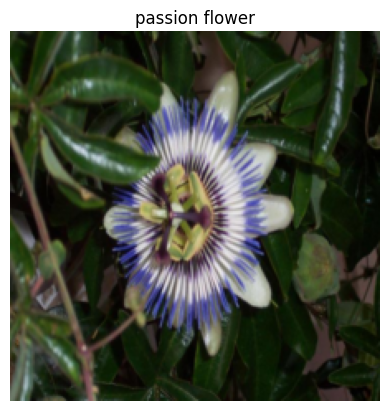

In [49]:
plt.imshow(image.permute(1, 2, 0))
plt.title(flower_names[classes[label]])
plt.axis(False)
plt.show()

## *Show off batch of images*

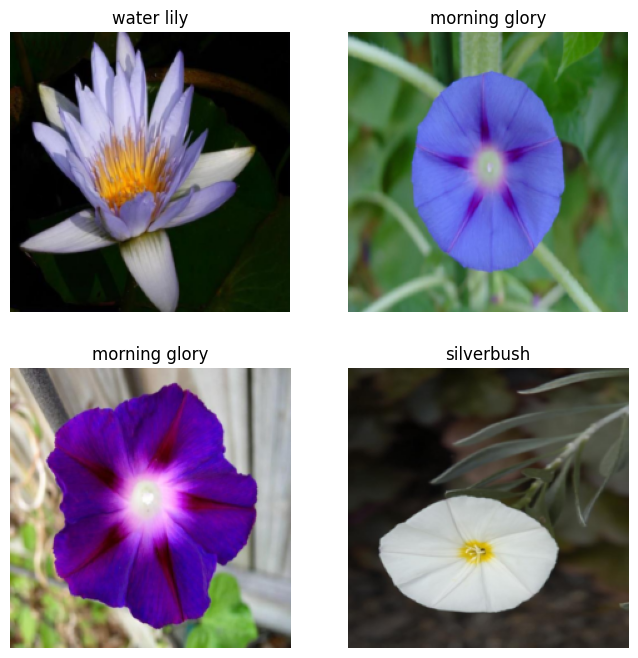

In [52]:
def show_batch(dataloader, batch_size:int):
    """Displays a batch of images from the dataloader in a grid format."""
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(int(np.sqrt(batch_size)), int(np.sqrt(batch_size)), figsize=(8, 8))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.permute(1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
        ax.set_title(flower_names[classes[label.item()]])  # Convert tensor label to integer
        ax.axis("off")  # Hide axes
    
    plt.show()

show_batch(train_dataloader, 
           batch_size=BATCH_SIZE)

# Simple ANN

In [57]:
class Oxford_Modelv0_SimpleANN(nn.Module):
    def __init__(self, input_shape: int,
                hidden_units: int,
                hidden_layers: int,
                output_shape: int,
                activations: nn.Module):
        super().__init__()

        layers = [nn.Flatten()]                                                               # Start with Flatten Layer
        
        layers.append(nn.Linear(in_features=input_shape, out_features= hidden_units))        # Adding input layers
        layers.append(activations)

        for _ in range(hidden_layers - 1):                                                    # Adding dynamic hidden layer
            layers.append(nn.Linear(hidden_units, hidden_units))
            layers.append(activations)

        layers.append(nn.Linear(hidden_units, output_shape))                                  # Adding output layers


        self.layers = nn.Sequential(*layers)                                                  # Unpack list of layers into Sequential

    def forward(self, x):
        return self.layers(x)


modelv0 = Oxford_Modelv0_SimpleANN(input_shape = 150528, 
                               hidden_units = 10,
                               hidden_layers = 1,
                               output_shape= len(classes),
                               activations=nn.ReLU()).to(device)

modelv0

# summary(model=oxford_modelv0,
#        input_size=224,
#        col_names=["input_size", "output_size", "num_params", "trainable"],
#        col_width=25,
#        row_settings=["var_names"])
        

Oxford_Modelv0_SimpleANN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=102, bias=True)
  )
)

In [ ]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=modelv0.parameters(), lr = 0.01)

# Callback


# Train model
modelv0_result = utils.train_model(model=modelv0,
                             train_dataloader=train_dataloader,
                             test_dataloader=valid_dataloader,
                             optimizer=optimizer,
                             loss_fn=criterion,
                             epochs=2,
                             device=device)

# Save the model
utils.save_model(model=modelv0)

# Evaluate learning curve
utils.plot_loss_curves(modelv0_result)


# Simple CNN

In [55]:
class Oxford_modelv1_SimpleCNN(nn.Module):
    def __init__(self, num_classes=102):  # 102 flower categories
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # (224x224x3) -> (224x224x32)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)  # Downsample (112x112x32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (112x112x32) -> (112x112x64)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # (56x56x128)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Flatten layer
        self.fc2 = nn.Linear(512, num_classes)   # Output 102 classes

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  
        x = torch.flatten(x, 1)  # Flatten for FC layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation here (CrossEntropyLoss applies softmax)
        return x


modelv1 = Oxford_modelv1_SimpleCNN()
modelv1

Oxford_modelv1_SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
)

# TinyVGG

In [32]:
class Oxford_Modelv2_TinyVGG(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape: int) -> None:
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1), nn.ReLU(),
            
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1), nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )

    def forward(self, x:torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.classifier(x)

torch.manual_seed(16)
modelv2 = Oxford_Modelv2_TinyVGG(input_shape=224,
                                hidden_units=10,
                                output_shape=102).to(device)

modelv2
    
    

Oxford_Modelv2_TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(224, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=102, bias=True)
  )
)

# TinyVGG (customed)

In [34]:
modelv2_customed = Oxford_Modelv2_TinyVGG(input_shape=224,
                                hidden_units=10,
                                output_shape=102)

modelv2_customed.classifier = Oxford_Modelv0_SimpleANN(input_shape =102, 
                               hidden_units = 10,
                               hidden_layers = 1,
                               output_shape= len(classes),
                               activations=nn.ReLU())
modelv2_customed



Oxford_Modelv2_TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(224, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Oxford_Modelv0_SimpleANN(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=102, out_features=10, bias=True)
      (2): ReLU()
      (3): Linear(in_features=10, out_features=102, bias=True)
    )
  )
)

# ViT

In [ ]:
Stop right here

 # Pre-trained ViT

In [ ]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = models.ViT_B_16_Weights.DEFAULT 
pretrained_vit = models.vit_b_16(weights=pretrained_vit_weights).to(device)



## *Freeze the base Paramaters*

In [ ]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False


## *Change the classified head*

In [ ]:
# Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(classes)).to(device)
pretrained_vit

## *Summarize model*

In [ ]:
summary(model=pretrained_vit,
        input_size=(NUM_WORKERS, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=25,
        row_settings=["var_names"]
)

## *Pre-trained ViT transform*

In [ ]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

## *Setup DataLoader*

In [ ]:
train_dataloader_pretrained, \
    test_dataloader_pretrained, \
        class_names = create_dataloaders(train_dir=train_dir,
                                        valid_dir=valid_dir,
                                        transform=pretrained_vit_transforms,
                                        batch_size=NUM_WORKERS) 

train_dataloader_pretrained, \
    test_dataloader_pretrained, \
        f"{class_names}"

## *Training Pre-trained ViT*

In [ ]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_results = train_model(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=2,
                                      device=device)

In [ ]:
plot_loss_curves(pretrained_vit_results)



##  *Save the model*


In [ ]:
# Save the model
utils.save_model(model=pretrained_vit)

## Inference